# The Effects of COVID-19 on Crime Rates in Vancouver

### Group Project Final Report

Sean Lee, Neil Li, Tracy Wang, Wendi Zhong

## Introduction

Before the pandemic, our teammate Neil has experienced no crimes more major than perhaps public drunkeness, but once the pandemic started, he has been subjected to two different attempts of grand theft auto and one shooting. This can't help but make us wonder: is this simply a streak of bad luck or is this the result of the pandemic?

But it wasn't so simple, as research (Nivette et. al., 2021) has shown that crime rate decreases due to lockdowns forcing people to stay in their homes, there are also arguments to be had about how the economic downturn (Munywoki, 2020) could lead more people into commiting crimes for financial reasons.

The result of this could have fascinating ramifications, and it could inform governments on the potential social benefits of providing stimulus cheques.

### Research Question:

<b>Has Covid 19 increased the proportion of financially motivated crimes in Vancouver?<b>
    
### Hypothesis:

$H_0: p_1 - p_2 \geq 0$ vs $H_1: p_1 - p_2 \lt 0$
    
$p_1$: proportion of financially motivated crimes before the pandemic
    
$p_2$: proportion of financially motivated crimes after the pandemic
    
The null hypothesis states that the proportion of financially motivated crimes decreased or stayed the same since the pandemic started, while the alternative hypothesis states that the crime rate increased since the pandemic started.
    
We will compare the results of our hypothesis test to a significance level of $\alpha$ = 0.05, as this is the most common significance level.

In [1]:
# Loading libraries
library(tidyverse)
library(datateachr)
library(repr)
library(digest)
library(infer)
library(grid)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Dataset Info:

The dataset is downloaded from \"[Vancouver Crime Data](https://geodash.vpd.ca/opendata/)\", an open data dataset provided by the Vancouver Police Department. Which we selected to list all the the crimes recorded in every neighbourhood in Vancouver since 2003. The dataset (Vancouver Crime Data) of specific crimes is directly downloaded from the Vancouver Police Department. We are confident that the dataset is trustworthy and representative with no bias in the data; even if there could still be unreported crimes.

In [2]:
# reading data
crimes_url <- "https://raw.githubusercontent.com/NeilLi26/STAT201-project/main/crimedata_csv_AllNeighbourhoods_AllYears.csv"
crime_data <- read.csv(crimes_url)
head(crime_data)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Break and Enter Commercial,2012,12,14,8,52,,Oakridge,491285.0,5453433
2,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
3,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
4,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
5,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
6,Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166


Because we want to have the crime data be more representative of the difference between the years leading up to the pandemic to the years during and after the pandemic, we will filter the data to only include years from 2017 onwards, and before November since 2022 has not had a November yet. We will also only need the columns containing the type of the crime, year the crime was committed.

In [3]:
# selecting data after 2017 and before November
crime_data_processed <- crime_data %>%
    filter(YEAR >= 2017, MONTH <= 10) %>%
    select(TYPE, YEAR)
head(crime_data_processed)

,TYPE,YEAR
,<chr>,<int>
1,Break and Enter Commercial,2019
2,Break and Enter Commercial,2019
3,Break and Enter Commercial,2021
4,Break and Enter Commercial,2020
5,Break and Enter Commercial,2022
6,Break and Enter Commercial,2022


We want to know what kinds of crimes are present, in order for us to determine what kinds of crimes present could be considered as financially motivated.

In [4]:
crime_types <- crime_data_processed %>%
    select(TYPE) %>%
    group_by(TYPE) %>%
    summarise(n = n()) %>%
    select(TYPE)
crime_types

TYPE
<chr>
Break and Enter Commercial
Break and Enter Residential/Other
Homicide
Mischief
Offence Against a Person
Other Theft
Theft from Vehicle
Theft of Bicycle
Theft of Vehicle


We deem the "Breaking and Entering" and "Theft" type crimes to be financially motivated. This was decided from the tibble above, and some further research by ourselves (Ferguson E., 2015).

The financial crimes are stored in the tibble below:

In [5]:
financial_crimes <- c("Break and Enter Commercial", "Break and Enter Residential/Other", "Other Theft", "Theft from Vehicle",
                     "Theft of Bicycle", "Theft of Vehicle")

## Methods and Results

### Bootstrapping

We first decided to use a bootstrap method to get a better understanding of what the difference of proportions look like, so that we could have good idea of what to expect when we move to hypothesis testing.

First of all, we would like to visualize the distribution of the difference of proportions, by taking a series of bootstrap samples and calculating the proportion of crimes that are financially motivated before and after the pandemic, and calculating the difference between these proportions.

The original sample size is chosen to be 2000 as that is a large enough sample size to decrease the likelihood of drawing an unrepresentative data set, but also one that is not too large as we found that to be too computationally intensive.

In [6]:
# take a single sample with size 2000 from population
set.seed(2190)
sample_size <- 2000
crime_sample <- crime_data_processed %>%
    rep_sample_n(size = sample_size, replace = FALSE) %>%
    mutate(Pandemic = ifelse(YEAR < 2020, "Before", "After"))
head(crime_sample)

replicate,TYPE,YEAR,Pandemic
<int>,<chr>,<int>,<chr>
1,Theft from Vehicle,2018,Before
1,Theft from Vehicle,2018,Before
1,Theft from Vehicle,2018,Before
1,Other Theft,2022,After
1,Mischief,2021,After
1,Theft of Bicycle,2017,Before


In [7]:
# create 1000 bootstrap samples with size 2000 of the difference in the proportion of financial crimes commited before the pandemic 
# (YEAR < 2020) 
set.seed(2190)
bootstrap_sample <- crime_sample %>%
    rep_sample_n(size = sample_size, reps = 1000, replace = TRUE) %>%
    group_by(replicate...1,Pandemic) %>%
    summarize(prop = sum(TYPE %in% financial_crimes)/n())%>%
    pivot_wider(names_from = Pandemic, values_from = prop)%>%
    mutate(diff = Before - After)%>%
    rename(replicate = `replicate...1`)
head(bootstrap_sample)

New names:
• `replicate` -> `replicate...1`
• `replicate` -> `replicate...2`
`summarise()` has grouped output by 'replicate...1'. You can override using the
`.groups` argument.


replicate,After,Before,diff
<int>,<dbl>,<dbl>,<dbl>
1,0.7321637,0.7764192,0.04425547
2,0.6730310,0.7796902,0.10665916
3,0.7051282,0.7845884,0.07946024
4,0.7204059,0.7744834,0.05407752
5,0.6980256,0.7682177,0.07019218
6,0.7209302,0.7827557,0.06182547


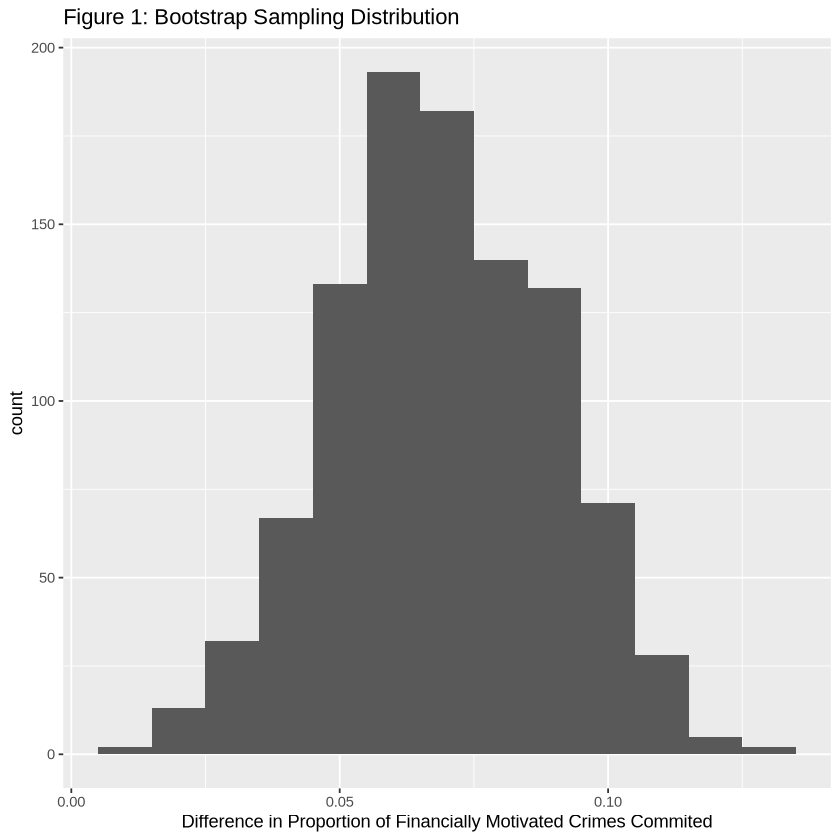

In [8]:
#Visualize the bootstrap distribution
bootstrap_sampling_distribution <- bootstrap_sample%>%
    ggplot(aes(x = diff)) +
    geom_histogram(binwidth = 0.01) +
    xlab("Difference in Proportion of Financially Motivated Crimes Commited") +
    ggtitle("Figure 1: Bootstrap Sampling Distribution") 
    
bootstrap_sampling_distribution

We then calculate all the important statistics, such as the mean, variance, and the 95% confidence interval. This was done so that we could better see what proportion of the differences may lie above or below 0. In our case after observing the histogram above, we would be more interested in seeing what proportion is actaully below 0.

In [9]:
# calculate the mean and var of difference in crimes commited
sample_mean_proportion <- mean(bootstrap_sample$diff)
sample_proportion_var <- var(bootstrap_sample$diff)

#obtain 95% confidence interval 
ci <- bootstrap_sample %>%
    get_ci(level = 0.95, type = "percentile")
bootstrap_Table <- data.frame(sample_mean_proportion, sample_proportion_var) %>%
    merge(ci)
bootstrap_Table

sample_mean_proportion,sample_proportion_var,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
0.06899849,0.0004092966,0.0304651,0.1075528


These statistics could be more meaningfully portrayed on a plot, so we added a blue semi-transparent rectangle to represent the confidence interval, with a red line to represent the mean.

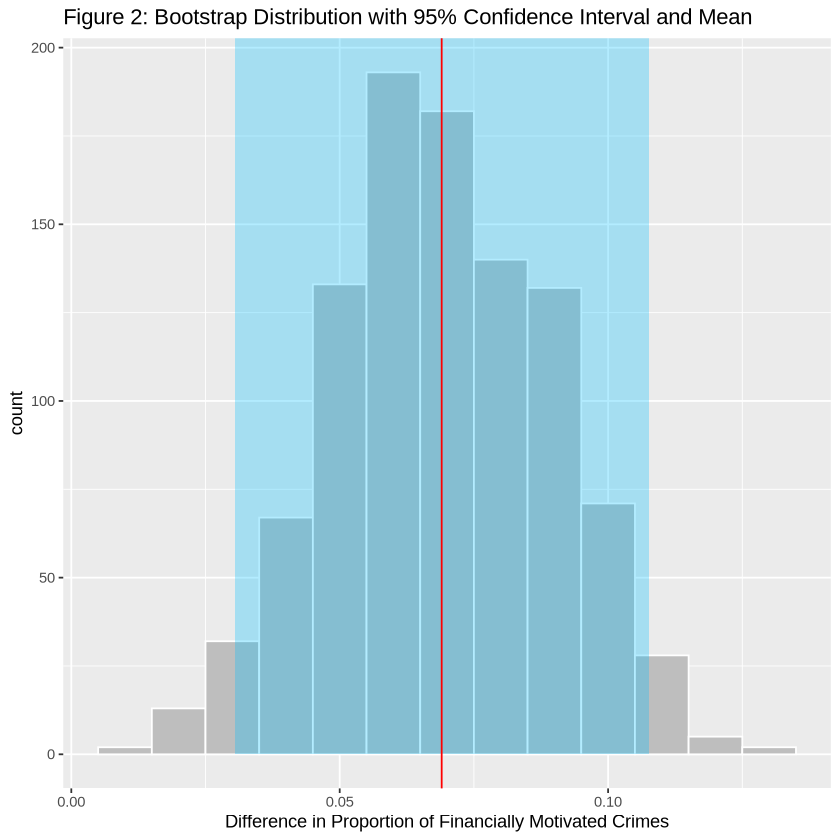

In [10]:
#Visualize the bootstrap distribution with 95% confidence interval
ci_plot <- bootstrap_sample%>%
    ggplot(aes(x = diff)) +
    geom_histogram (binwidth = 0.01, colour = "white", fill = "grey") +
    annotate("rect", xmin = ci$lower_ci, xmax = ci$upper_ci, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    xlab("Difference in Proportion of Financially Motivated Crimes")+
    ggtitle("Figure 2: Bootstrap Distribution with 95% Confidence Interval and Mean") +
    geom_vline(aes(xintercept= sample_mean_proportion), colour = "red")
ci_plot

We then create a null model by recentering the distribution above to be centered at our value of interest: 0, and calculate for the mean difference of proportions of all the bootstrap values. We can see how likely it is for the null model to be true by finding the proportion of points in our null model that has values lower than the observed test statistic

In [11]:
## make hypothesis test for difference proportions based 
# on bootstrapping methods, see Tutorial 6 question 3 for examples

# calculate observed test statistic
obs_test_stat <- mean(bootstrap_sample$diff)
print(paste("test statistic: ", obs_test_stat))

# construct null model
null_model <- 
    bootstrap_sample %>% 
    mutate(stat = diff - (obs_test_stat - 0 ) )

# obtain p-value
p_value <- mean(null_model$stat < obs_test_stat)

print(paste("p value: ", p_value))

[1] "test statistic:  0.068998489073459"
[1] "p value:  1"


This incredibly high p value would suggest of 1 that all of the data points in the null model are below the observed test statistic, meaning that it is almost guaranteed for the null hypothesis to be true according to the bootstrap method. 

We decided to visualise this on the plot below too, by placing a red line at our test statistic. And it is evident that all data points in the null distribution are to the left of this line.

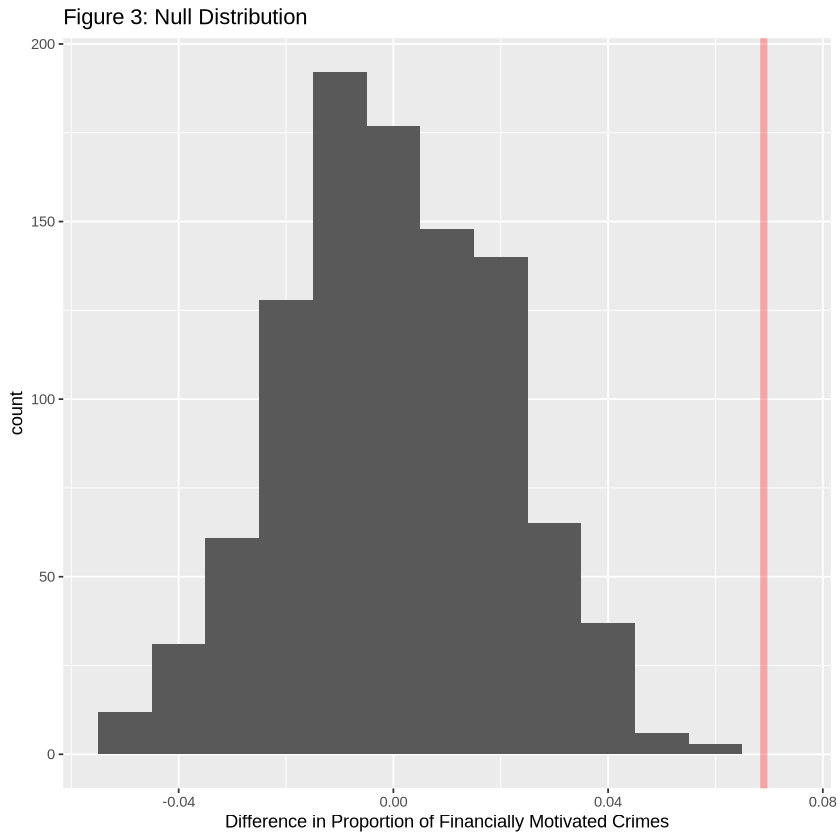

In [12]:
# visualize the null model
null_model_plot <-
    null_model %>%
    ggplot(aes(x = stat)) +
    geom_histogram(binwidth = 0.01) +
    geom_vline(xintercept = obs_test_stat, color = "red", alpha=.3, lwd=2)  +
    xlab("Difference in Proportion of Financially Motivated Crimes") +
    ggtitle("Figure 3: Null Distribution") 

null_model_plot

We would still like to see what results the central limit theroem and theory based approaches might yield.

### CLT Based Approach

For comparison's sake, we were also interested in how different the results we got from theoretical calculations would differ compared to the results we got using bootstrapping. So using the same seed, we took some samples first to get a proper confidence interval again, to see how much of the distribution is below 0.

Because this is a large dataset, we have the luxury of creating many large samples, and with those large samples we could apply the central limit theorem to get the same crucial data that we got before. First we took 1000 samples of size 2000, as we want many large samples for the central limit theorem to produce the most normal distribution. Then we plotted this on a graph, as seen below.

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


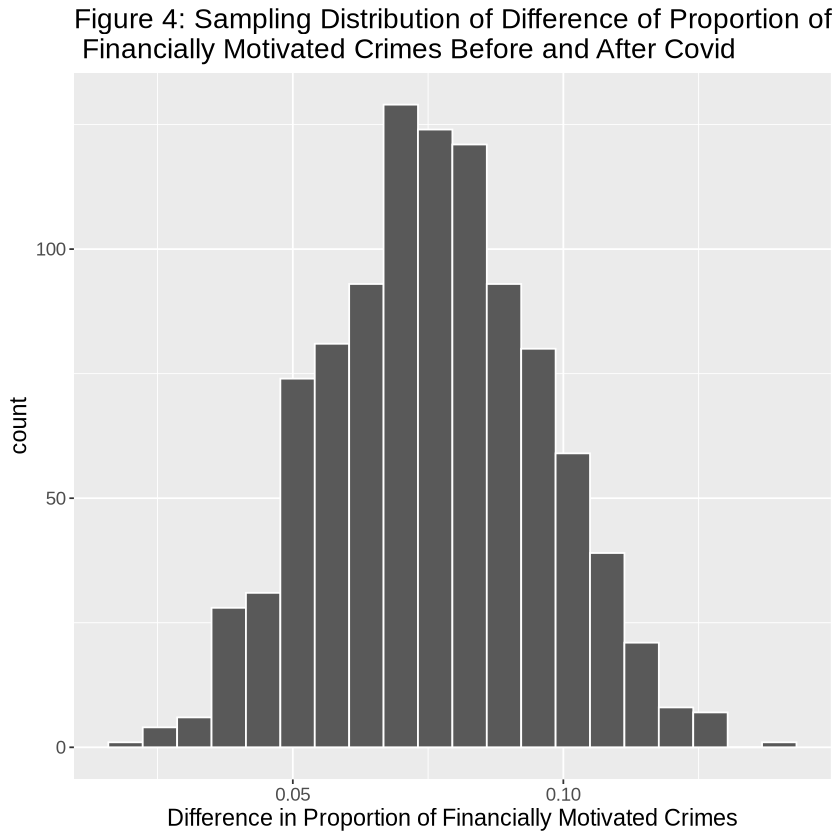

In [13]:
# take 1000 single sample with size 2000 from population
set.seed(2190)

samples_CLT <- crime_data_processed %>%
    rep_sample_n(size = 2000, reps = 1000, replace = FALSE) %>%
    mutate(Pandemic = ifelse(YEAR < 2020, "Before", "After"))

# calculate difference of crimes before and after 2020
diff_sampling_dist_CLT <- 
samples_CLT %>%
    group_by(replicate , Pandemic)%>%
    summarize(prop = sum(TYPE %in% financial_crimes)/n()) %>%
    pivot_wider(names_from = Pandemic, values_from = prop) %>%
    mutate(diff = Before - After) 

# Visualize size 2000 sampling distribution
diff_sampling_dist_plot_CLT <- 
diff_sampling_dist_CLT %>%
   ggplot(aes(x = diff)) +
   geom_histogram(bins = 20, color = 'white') +
   ggtitle("Figure 4: Sampling Distribution of Difference of Proportion of \n Financially Motivated Crimes Before and After Covid") +
   xlab("Difference in Proportion of Financially Motivated Crimes") +
   theme(text = element_text(size = 14))
diff_sampling_dist_plot_CLT

For comparison's sake, we were also interested in how different the results we got from theoretical calculations would differ compared to the results we got using bootstrapping. So using the same seed, we took some samples first to get a proper confidence interval again, to see how much of the distribution is below 0.

In [14]:
# Get mean and var of sampling distribution
mean_CLT <- mean(diff_sampling_dist_CLT$diff)
var_CLT <- var(diff_sampling_dist_CLT$diff)

# Get 95% confidence interval
ci_CLT <- diff_sampling_dist_CLT %>%
            get_confidence_interval(type = "percentile", level = 0.95)

CLT_table <- data.frame(mean_CLT, var_CLT) %>%
    merge(ci_CLT)
CLT_table
bootstrap_Table

mean_CLT,var_CLT,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
0.07614525,0.0003860956,0.0390271,0.1134796


sample_mean_proportion,sample_proportion_var,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
0.06899849,0.0004092966,0.0304651,0.1075528


From the tables above, it seems that the central limit theorem and bootstrap methods seem to yield very similar results. This is good but still we would trust the bootstrap method more as it makes less assumptions, especially about the independence of data points since it is possible that crimes have an impact on future crimes.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


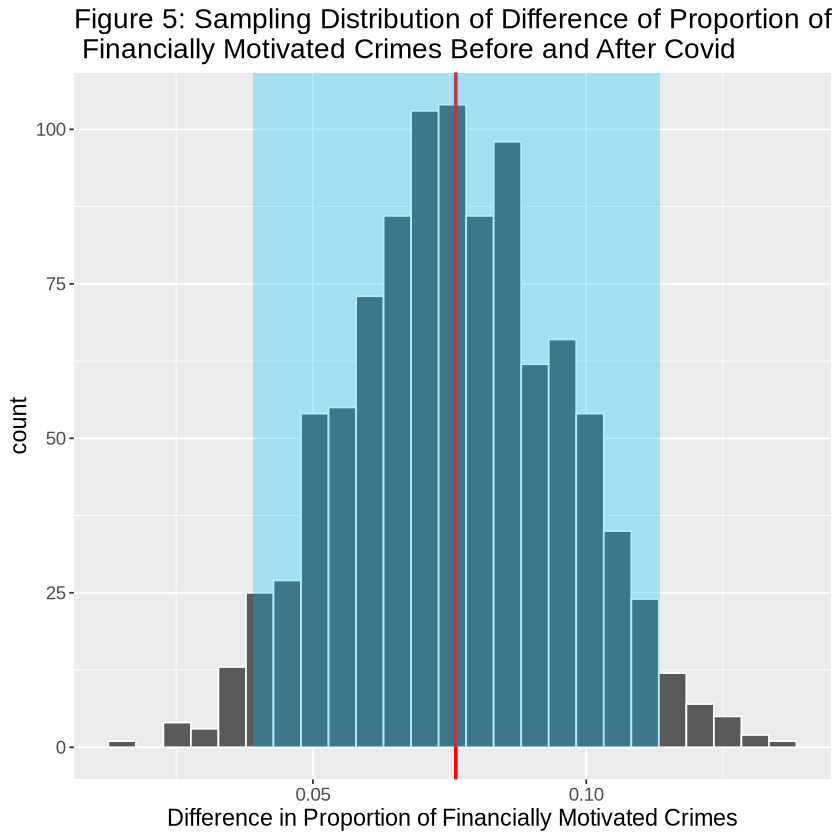

In [15]:
# lab mean on the sampling distribution
# shade 95% confidence interval on the sampling distribution

sample_quantile_plot <- 
    diff_sampling_dist_CLT %>% 
      ggplot(aes(x = diff)) +
      geom_histogram(bins = 25, color = 'white') +
      geom_vline(xintercept = mean_CLT, colour = "red", size = 1) +
      annotate("rect", 
              xmin = ci_CLT$lower_ci,
              xmax = ci_CLT$upper_ci,
              ymin = 0,
              ymax = Inf,
              fill = "deepskyblue",
              alpha = 0.3) +
      ggtitle("Figure 5: Sampling Distribution of Difference of Proportion of \n Financially Motivated Crimes Before and After Covid") +
      xlab("Difference in Proportion of Financially Motivated Crimes") +
      theme(text = element_text(size = 14))

sample_quantile_plot

From this point, it appears that the proportions are all consistently above 0, and the 95% confidence interval does not contain any values below 0. This suggests that it is very likely that the proportion of crimes that are financially motivated has decreased since the pandemic has started, but we would still like to perform a hypothesis test to confirm our suspicions. We first want to take a single large sample of size 2000, as that is a large amount of data points that is still less than 10% of our total population size. Then, we find the necessary data that we need for the hypothesis test, which is the proportion of financially motivated crimes and number of financially motivated crimes before and after the pandemic.

In [16]:
## do hypothesis testing for the difference in proportions based on the central limit theorem, see worksheet 8 question question 3.4 for examples
set.seed(2190)
sample_size <- 2000

samples_hypothesis <- crime_data_processed %>%
    rep_sample_n(size = 2000, reps = 1, replace = FALSE) %>%
    mutate(Pandemic = ifelse(YEAR < 2020, "Before", "After")) %>%
    group_by(replicate,Pandemic) %>%
    summarize(n = n(),
              prop = sum(TYPE %in% financial_crimes)/n())

samples_hypothesis

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,Pandemic,n,prop
<int>,<chr>,<int>,<dbl>
1,After,863,0.7056779
1,Before,1137,0.7748461


Using this information, we could then use the formulas learnt in our stat 201 class to calculate for the test statistic. We can use the pnorm function here as due to the large data size, we can assume normality and not bother with t-distributions.

In [17]:
# number of data points and proportions
n1 <- samples_hypothesis$n[1]
n2 <-samples_hypothesis$n[2]
p1 <- samples_hypothesis$prop[1]
p2 <- samples_hypothesis$prop[2]
p_hat <- (n1*p1 + n2*p2)/(n1 + n2)

test_statistic_theoretical <- (p2 - p1)/sqrt(p_hat * (1 - p_hat) * (1/n1 + 1/n2))

p_score_theoretical <- pnorm(test_statistic_theoretical, lower.tail = TRUE)
p_score_theoretical

[1] 0.9997801

This is once again a very high p-value, and it lines up very well with what we discovered in our bootstrap method.

## Discussion

Our hypothesis (research question) was: <b>Has Covid-19 affected the proportion of financially motivated crimes in Vancouver?<b>
    
The results were quite unexpected for us.
    
First, the visualization of bootstrapped sample has a normally distributed shape. Unless the bootstrapped plot is not normal, we could trust the bootstrap results. Since the distribution is easier to identify with more samples, our bootstrapped data has 1000 samples of replacements. The 95% CI is shaded blue in the plot, with the sample mean indicated as vertical red line. Our sample mean value of 0.06899849 represents the mean difference in proportion of crimes of Before and After COVID. The positive value sample mean indicates that there is an increase in crimes comparing "After" and "Before" crime rates. Negative value indicates the opposing result. However, as we could interpret from the distribution, there is only positive "diff" in crime rates from "After" and "Before". 
    
    Before - After = +ve
    
Moreover, we have 95% confidence interval with lower CI of 0.0304651 and upper CI of 0.1075528. This implies 95% of our difference in proportion of "Before" and "After" lies between the lower and upper CI. Our data is 95% confident that there is a difference in proportion, hence we are 95% confident the crime rates decreased comparing "Before" and "After" COVID.

We have calculated the p-value of 0.000439704868509851 from from calculating the proportions. The p-value tells us how likely our data could occur under our null hypothesis. Normally, a p-value of less than 0.05 is considered statistically significant, hence rejecting the null hypothesis. Since we have a much lower p-value than 0.05, we could have this as a statistical evidence to reject the null hypothesis.
    
Therefore, COVID 19 has not affected the proportion of financially motivated crimes in Vancouver to increase.
    
We had the research question from our personal experience of experiencing more frequent crimes during the pandemic. However, it turns out that statistically there is no increase in crime rates after the pandemic. The results were quite expected as we were expecting to see increased crimes after pandemic. 

    
    
    
Possible limitations: 
- Even though we classifed ourselves "Breaking and Entering" and "Theft" to be financially motivated crimes, the dataset does not tell us whether they are truly motivated by financial extortion.
- We are missing data from 2022 November to December as "After" COVID when we started this research. However, it could still be doubtful whether 2022 November and December data would have significant effect on our results. 
- The boundary between "Before" and "After" the pandemic could be vague. There is no specific date or time to diverge the period of the pandemic. When is the exact start and end for COVID? There were times when COVID was definitely more severe, and when the bad things were alleviated. But it is not easy to clearly differentiate the years as "Before" and "After" COVID.

    
Further questions:
- Based on our possible limitations, we could focus more on crimes that involved financial activities to distinguish the real motive for the crimes. Perhaps, phishing scams, second-hand trading scams, or even financial fraud targetted to financially better off.
- There could be a difference of crime rates where ecomonic downturn was harsher than Vancouver or not. Maybe the economic status could have been a more significant factor in handling the pandemic.

# References:

Ferguson, E. (2015). Crime and punishment vocabulary with pronunciation. IELTS Liz. Retrieved October 31, 2022, from https://ieltsliz.com/crime-and-punishment-vocabulary/ 

Munywoki, G. (2020). Economic effects of novel coronavirus (COVID – 19) on the global economy. SSRN Electronic Journal. https://doi.org/10.2139/ssrn.3719130 

n.a. (n.d.). Crime Data Download. VPD open data. Retrieved October 31, 2022, from https://geodash.vpd.ca/opendata/ 

Nivette, A.E., Zahnow, R., Aguilar, R. et al. A global analysis of the impact of COVID-19 stay-at-home restrictions on crime. Nat Hum Behav 5, 868–877 (2021). https://doi.org/10.1038/s41562-021-01139-z